### 1. Importing Required Modules and Packages

In [1]:
import os
import sys

sys.path.append('..')
os.environ["OMP_NUM_THREADS"] = '1'  # KMeans is not parallelized, so set to 1 thread

from src.mutation import Mutation
from src.sequence import Vector, Gene
from src.eblocks import Eblock, EblockDesign
import biotite.sequence as seq
from src.primer import DesignPrimers
from src.plot import Plot

%reload_ext autoreload
%autoreload 2

### 2. Loading and Analyzing the Gene Sequence

The desired mutations should be added to a txt file. 
Here, we create a Mutation() object and parse the specified mutations. 

In [56]:
# Create a Mutation object and parse the input mutations from the files/ directory

mutations_file = os.path.join('tests', 'randominput', '100_A0QX55_mutations.txt')

mutation_instance = Mutation()
mutation_instance.parse_mutations(mutations_file)

# Print the mutations that were parsed
mutation_instance.print_mutations()

The selected mutations are:
	Deletion  	L13-H14   
	Mutation  	N50Q      
	Insert    	E56-M     
	Deletion  	I70-P78   
	Mutation  	E73H      
	Deletion  	R85-G90   
	Combined  	S93V, S129V
	Combined  	G117C, T165L, L134W
	Mutation  	L222F     
	Deletion  	A223-H228 
	Insert    	C227-RAVSES
	Mutation  	A234W     
	Mutation  	V244T     
	Deletion  	V244-P253 
	Deletion  	V244-D252 
	Mutation  	T246A     
	Insert    	R255-RHGKCGM
	Deletion  	S267-A269 
	Mutation  	D276S     
	Mutation  	S285G     
	Combined  	S319L, Y341W
	Mutation  	G328K     
	Combined  	L329D, A345C, G356P, D366E, A335T
	Insert    	F333-YIKMAL
	Deletion  	S354-K355 
	Mutation  	K355M     
	Deletion  	G379-R382 
	Deletion  	V390-G395 
	Insert    	I396-EGESQYICL
	Mutation  	M434V     
	Deletion  	A448-K457 
	Deletion  	K457-T458 
	Combined  	T458S, T500P
	Mutation  	D479P     
	Combined  	D493P, L536D, A510V, P495L, D501P
	Deletion  	E518-T525 
	Mutation  	Q528V     
	Insert    	I537-CK   
	Deletion  	A546-I548 
	Mutati

Next, we read the gene sequence and the vector that contains our gene of interest.

In [57]:
# Create a Plasmid object and parse the input plasmid from the files/ directory

# Read sequence
sequence_file = os.path.join('example_data', 'Msmegmatis_DnaE1', 'A0QX55.fasta')
vector_file = os.path.join('example_data', 'Msmegmatis_DnaE1', 'vector.dna')

gene_instance = Gene()
gene_instance.parse_sequence(sequence_file)
vector_instance = Vector(gene=gene_instance)
vector_instance.parse_vector(vector_file)

We also define an output directory for the generated files and create a snapgene object for visualization

We create an eBlockDesign instance that can initiate the design of the eblocks. Here, we choose as optimization method cost_optimization that aims to use as little basepairs as possible. Another option would be to do amount_optimization, that aims to cluster as many mutations as possible together, to get the lowest number of different eBlocks

In [65]:
# Create an Eblocks object based on the input mutations and the gene sequence

output_dir = os.path.join('tests', 'randomoutput', 'output')

design_instance = EblockDesign(mutation_instance=mutation_instance,
                            gene_instance=gene_instance,
                            vector_instance=vector_instance,
                            output_dir=output_dir,
                            verbose=True,
                            cost_optimization=False,
                            amount_optimization=True)

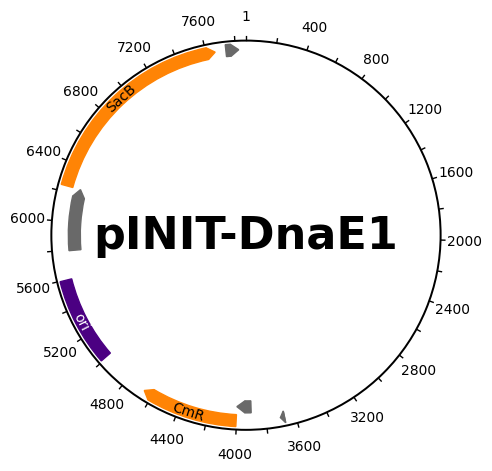

In [66]:
# Create a Plots object and check the input vector

# Create the Plot object
plot_instance = Plot(mutation_instance=mutation_instance,
                    eblocks_design_instance=design_instance,
                    vector_instance=vector_instance,
                    gene_instance=gene_instance,
                    output_dir=output_dir,
                    show=True)

# Check the input vector
plot_instance.plot_vector(figsize=(5, 5));

In [73]:
# Run the eBlocks design and print the results
design_instance.run_design_eblocks()
plot_instance.plot_eblocks_mutations(figure_length=25,
                                     figure_width=5)

Calculating relative codon frequencies, based on the selected genome id U00096 ...


In the process, for each mutation a different eBlock is created and a .gb file is made to easily view the clone in a sequence editor. 

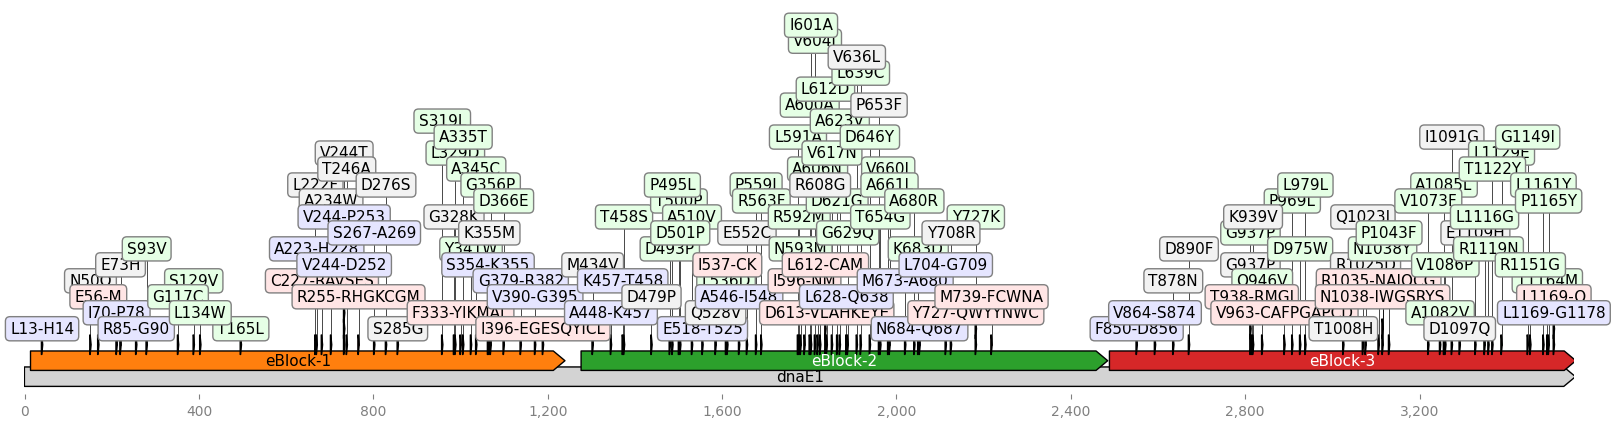

In [64]:
for eblock in design_instance.wt_eblocks:
    print(eblock.name, len(eblock.sequence))

print(mutation_instance.unprocessed_mutations[0].name)

eBlock-1 1226
eBlock-2 1208
eBlock-3 1070
A807E-T815L-V838N-D820M-G847K


In [ ]:
sequence_file = 'files/A0QX55.fasta'
vector_file = 'files/vector.dna'

sequence_instance = Plasmid()
sequence_instance.parse_vector(vector_file)
sequence_instance.parse_sequence(sequence_file)

sequence_instance.description

In [23]:
from Bio import SeqIO

def read_single_fasta(fp: str) -> str:
    """
    This function reads a single fasta file and returns the sequence.
    """
    for num, record in enumerate(SeqIO.parse(fp, "fasta")):
        sequence = record.seq
        seqid = record.id
        if num > 0:
            raise ValueError("Please provide a single sequence in FASTA format.")
    return sequence, seqid

def read_single_fasta(fp: str) -> str:
    """
    This function reads a single fasta file and returns the sequence.
    """
    record = next(SeqIO.parse(fp, "fasta"))  # Read the first and only record
    sequence = record.seq
    seqid = record.id
    return sequence, seqid

In [ ]:
seq, seqid = read_single_fasta(sequence_file)
print(seq, seqid)
seq, seqid = read_single_fasta2(sequence_file)
print(seq, seqid)